In [14]:
%matplotlib inline


Batch Mode Reinforcement Learning DQN PytTorch - Mountaincar
=====================================





In [15]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


env = gym.make('MountainCar-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Replay Memory
-------------

or this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [16]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

DQN algorithm
-------------




In [17]:
class DQN(nn.Module):

    def __init__(self, state_dim, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 150)
        self.fc2 = nn.Linear(150, 75)
        self.fc3 = nn.Linear(75, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Return Q values
        return x # num_actions, gives the Q value for each
        
        # return action probabilities
        #action_probs = F.softmax(x, dim=0)

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``Variable`` - this is a simple wrapper around
   ``torch.autograd.Variable`` that will automatically send the data to
   the GPU every time we construct a Variable.
-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [18]:
from torch.distributions import Categorical

In [6]:
BATCH_SIZE = 12
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(2, 3) # state_dim, num_actions
target_net = DQN(2, 3) # state_dim, num_actions
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if use_cuda:
    policy_net = policy_net.cuda()
    target_net = target_net.cuda()

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)
memory = ReplayMemory(200000) # 13361 willl be used according to my tets

In [7]:
#### Not being used here. These are for a stochastic setup

steps_done = 0

def select_action_stochastic(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        action_probs = policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
        m = Categorical(action_probs)
        action = m.sample()
        return action
    else:
        return LongTensor([[random.randrange(3)]])
    
def select_action(state):
    action_probs = policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

Training loop
^^^^^^^^^^^^^



Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [8]:
def is_terminal(state):
    #Terminal position is 0.5
    return state[0] >= 0.5

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Sample transitions from buffer
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: not is_terminal(s),
                                          batch.next_state)))

    # Select all s' that are not final
    non_final_next_states = Variable(torch.cat([FloatTensor(s) for s in batch.next_state
                                                if not is_terminal(s)]),
                                     volatile=True)
       
    state_batch = Variable(torch.cat([FloatTensor(s) for s in batch.state]))
    action_batch = Variable(LongTensor(batch.action))
    reward_batch = Variable(FloatTensor(batch.reward))
    
    batch_size = min(BATCH_SIZE,state_batch.size()[0]/2) #Position vel pair hence divide by 2.
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    
    # Returns [Q(s,a_1), Q(s,a_2), Q(s,a_3)] for each state
    Q_values_all_actions = policy_net(state_batch.view(batch_size,2))
    
    # Returns [Q(s, a_i)] where a_i comes from action_batch
    Q_values_selected_actions = Q_values_all_actions.gather(1, action_batch.view(-1, 1))
    

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(batch_size).type(Tensor))
    
    #import pdb; pdb.set_trace()
    #.max(1) does an argmax
    
    next_state_values[non_final_mask] = (target_net(non_final_next_states.view(-1,2)).max(1)[0])
    
    # Compute the expected Q values
    expected_Q_values_selected_actions = (next_state_values * GAMMA) + reward_batch
    
    # Undo volatility (which was used to prevent unnecessary gradients)
    expected_Q_values_selected_actions = Variable(expected_Q_values_selected_actions.data)
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(Q_values_selected_actions, expected_Q_values_selected_actions)

    # Optimize the model
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss

# Collect off-policy samples

In [10]:
from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *

## Generate samples

In [11]:
import random
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
    
class StochasticPolicy():
    def __init__(self):
        self.manual_policy = ManualPolicy()
        self.random_policy = RandomPolicy2(choices=[0, 2]) # left, right

    def choose_action(self, s):
        if random.random() < 0.25:
            return self.random_policy.choose_action(s)
        else:
            return self.manual_policy.choose_action(s)
    
pi4 = ManualPolicy()

# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right

# for offline dqn
pi6 = StochasticPolicy()

In [12]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

In [ ]:
trajs_for_dqn = sim.simulate(pi4, n_trial=1, n_episode=1000)

In [ ]:
print("dimensions of trajs_for_dqn = {0} x ~{1}".format(len(trajs_for_dqn), len(trajs_for_dqn[0])))

In [ ]:
num_transitions = 0
for episode in trajs_for_dqn:
    num_transitions += len(episode)
print("number of transitions in trajs_for_dqn = {0}".format(num_transitions))

In [ ]:
print("example transition: {0}".format(trajs_for_dqn[0][0]))
terminal_position = 0.5

# Train!

### In our approach, we store *all* transition in the replay buffer.

In [54]:
for episode in trajs_for_dqn:
    for transition in episode:        
        # Store the transition in memory        
        memory.push(transition.s, transition.a, transition.s_next, transition.r)


100%|██████████| 50000/50000 [01:47<00:00, 465.35it/s]


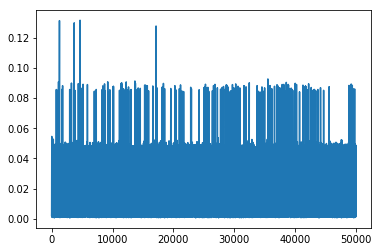

In [91]:
from tqdm import tqdm
loss = []
NUM_ITERATIONS = 50000
for iteration in tqdm(range(NUM_ITERATIONS)):
    loss.append(optimize_model().data[0])
    if iteration % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

plt.plot(range(len(loss)), loss)
plt.show()


## TEST OUTPUT

In [104]:
# Create a wrapper for the agent
# Wrapper so that choose_action is exposed
class Dqn_wrapper(object):
    def __init__(self, policy_net):
        self.policy_net = policy_net
        self.policy_net.eval()
    
    def choose_action(self, s):
        action = self.policy_net(Variable(FloatTensor(s))).max(0)[1]
        return action.data.cpu().numpy()[0]

In [ ]:
pi_dqn = Dqn_wrapper(policy_net)
D = sim.simulate(pi_dqn, 1, 200)
D_mat = Simulator.to_matrix(D)
